# **Model selection by Deep Neural Networks (DNN) for growth-rate $f\sigma_8$ data**
## [Tomographic Coupled Dark Energy](https://arxiv.org/abs/2211.13588) vs ΛCDM
Aim: test subtle differences between ΛCDM and CDE at the level of Large Scale Structure, galaxy clustering data. 
The data only takes into account the activation of one tomographic bin at a time:
\begin{equation}
\beta(z)=\frac{\beta_1+\beta_n}{2}+\frac{1}{2} \sum_{i=1}^{n-1}\left(\beta_{i+1}-\beta_i\right) \tanh \left[s_i\left(z-z_i\right)\right],
\end{equation}

with $n=3$ and redshift bin edges $z_i=\{0,100,1000\}$

In [4]:
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks
from matplotlib import pyplot as plt

Num_zs = 16
beta_bin = 1

### Read the data:
It was simulated out of [the CDE modified version of CLASS](https://github.com/LisaGoh/CDE.git) and a simulated DESI-like covariance matrix with SoapFish. We only take one tomographic bin activation: $\beta_1$

In [5]:
dataframe = pd.read_csv('./fs8_data/Training_beta%d.csv' %beta_bin)

In [7]:
dataframe.head()

,fs8_1,sfs8_1,fs8_2,sfs8_2,fs8_3,sfs8_3,fs8_4,sfs8_4,fs8_5,sfs8_5,...,sfs8_12,fs8_13,sfs8_13,fs8_14,sfs8_14,fs8_15,sfs8_15,fs8_16,sfs8_16,target
0,0.028757,0.006291,0.033717,0.00617,0.038449,0.00606,0.042823,0.005988,0.046748,0.005955,...,0.005767,0.061399,0.005687,0.061347,0.005598,0.061107,0.005503,0.060709,0.005402,0.0
1,0.029506,0.006291,0.034542,0.00617,0.039340,0.00606,0.043770,0.005988,0.047741,0.005955,...,0.005767,0.062452,0.005687,0.062384,0.005598,0.062126,0.005503,0.061709,0.005402,0.0
2,0.030265,0.006291,0.035378,0.00617,0.040243,0.00606,0.044729,0.005988,0.048746,0.005955,...,0.005767,0.063515,0.005687,0.063430,0.005598,0.063154,0.005503,0.062719,0.005402,0.0
3,0.031034,0.006291,0.036223,0.00617,0.041156,0.00606,0.045699,0.005988,0.049763,0.005955,...,0.005767,0.064586,0.005687,0.064486,0.005598,0.064191,0.005503,0.063736,0.005402,0.0
4,0.031812,0.006291,0.037079,0.00617,0.042079,0.00606,0.046679,0.005988,0.050789,0.005955,...,0.005767,0.065667,0.005687,0.065549,0.005598,0.065236,0.005503,0.064761,0.005402,0.0


In [8]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


Using 4000 samples for training and 1000 for validation


In [9]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [10]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'fs8_1': <tf.Tensor: shape=(), dtype=float64, numpy=0.3266635042037234>, 'sfs8_1': <tf.Tensor: shape=(), dtype=float64, numpy=0.0062907883211478>, 'fs8_2': <tf.Tensor: shape=(), dtype=float64, numpy=0.3462150701356286>, 'sfs8_2': <tf.Tensor: shape=(), dtype=float64, numpy=0.006169872581862>, 'fs8_3': <tf.Tensor: shape=(), dtype=float64, numpy=0.3603130127885074>, 'sfs8_3': <tf.Tensor: shape=(), dtype=float64, numpy=0.0060604502363361>, 'fs8_4': <tf.Tensor: shape=(), dtype=float64, numpy=0.3695031474874332>, 'sfs8_4': <tf.Tensor: shape=(), dtype=float64, numpy=0.005988240166869>, 'fs8_5': <tf.Tensor: shape=(), dtype=float64, numpy=0.3744579618654208>, 'sfs8_5': <tf.Tensor: shape=(), dtype=float64, numpy=0.0059549134745899>, 'fs8_6': <tf.Tensor: shape=(), dtype=float64, numpy=0.3745140354173445>, 'sfs8_6': <tf.Tensor: shape=(), dtype=float64, numpy=0.0059537321804849>, 'fs8_7': <tf.Tensor: shape=(), dtype=float64, numpy=0.3709356214703516>, 'sfs8_7': <tf.Tensor: shape=(), dtype=f

In [11]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

### Setting up and training the deep neural networks

In [12]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    #Normalization layer for our feature
    normalizer = Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    #Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

In [13]:
#Store inputs and encoded features
all_inputs = []
all_features_encoded = []

#Inputs and Encode numerical features
for i in range(1, Num_zs + 1):
    fs_input = keras.Input(shape=(1,), name=f"fs8_{i}")
    sfs_input = keras.Input(shape=(1,), name=f"sfs8_{i}")

    fs_encoded = encode_numerical_feature(fs_input, f"fs8_{i}", train_ds)
    sfs_encoded = encode_numerical_feature(sfs_input, f"sfs8_{i}", train_ds)

    all_inputs.extend([fs_input, sfs_input])
    all_features_encoded.extend([fs_encoded, sfs_encoded])

#Concatenate all encoded features
all_features = layers.concatenate(all_features_encoded)
x = layers.Dense(38, activation='relu', name='hidden_layer')(all_features)
x = layers.Dropout(0.224)(x)
output = layers.Dense(1, activation="sigmoid", name='output_layer')(x)

model = keras.Model(all_inputs, output)

#Compile the DNN
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

#Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50, #Number of epochs from where the accuracy and loss don't change
    restore_best_weights=True
)

In [14]:
NCC_1701_D=model.fit(train_ds, epochs=2000, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/2000
125/125 [==============================] - 4s 13ms/step - loss: 0.5600 - accuracy: 0.7010 - val_loss: 0.5130 - val_accuracy: 0.7480
Epoch 2/2000
125/125 [==============================] - 1s 7ms/step - loss: 0.5063 - accuracy: 0.7458 - val_loss: 0.4736 - val_accuracy: 0.7700
Epoch 3/2000
125/125 [==============================] - 1s 6ms/step - loss: 0.4821 - accuracy: 0.7678 - val_loss: 0.4555 - val_accuracy: 0.7840
Epoch 4/2000
125/125 [==============================] - 1s 7ms/step - loss: 0.4625 - accuracy: 0.7780 - val_loss: 0.4484 - val_accuracy: 0.7960
Epoch 5/2000
125/125 [==============================] - 1s 6ms/step - loss: 0.4536 - accuracy: 0.7822 - val_loss: 0.4347 - val_accuracy: 0.8080
Epoch 6/2000
125/125 [==============================] - 1s 6ms/step - loss: 0.4438 - accuracy: 0.7950 - val_loss: 0.4264 - val_accuracy: 0.8150
Epoch 7/2000
125/125 [==============================] - 1s 6ms/step - loss: 0.4317 - accuracy: 0.8030 - val_loss: 0.4183 - val_accuracy

### Learning curves

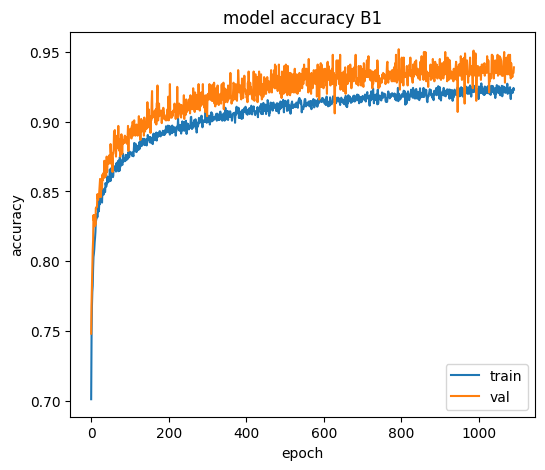

In [15]:
fig = plt.figure(figsize=(6,5))
plt.plot(NCC_1701_D.history['accuracy'])
plt.plot(NCC_1701_D.history['val_accuracy'])
plt.title('model accuracy B1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
fig.savefig('./plots/Beta%daccuracy.pdf' %beta_bin)

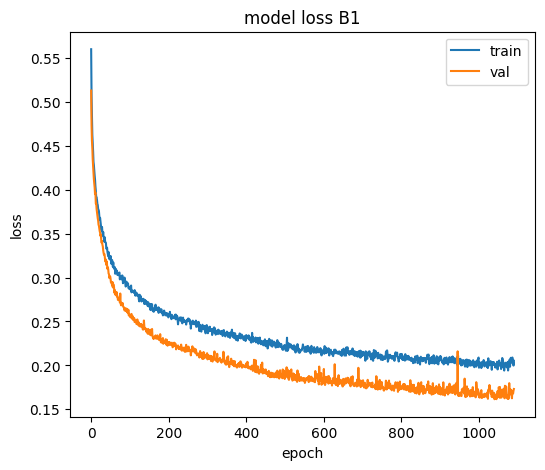

In [16]:
fig = plt.figure(figsize=(6,5))
plt.plot(NCC_1701_D.history['loss'])
plt.plot(NCC_1701_D.history['val_loss'])
plt.title('model loss B1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
fig.savefig('./plots/Beta%dloss.pdf' %beta_bin)

### Testing the DNNs

In [17]:
def norm(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

In [19]:
theory = ['LCDM','MoG']

with open('./fs8_data/Test_beta%d.csv' %beta_bin, 'r') as f:
    dict_reader = csv.DictReader(f,quoting=csv.QUOTE_NONNUMERIC)
    test_models = list(dict_reader)

In [20]:
true_model=[]
pred_model=[]
prob_pred=[]
for i in range(len(test_models)):
  sample = test_models[i]
  input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()} 
  predictions = model.predict(input_dict)
  true_model.append(round(test_models[i]['target']))
  pred_model.append(round(predictions[0][0]))
  prob_pred.append(round(100*norm(predictions[0][0]),3))

c:\Users\indi_\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py:642: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 0s 157ms/step


In [21]:
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []
for i in range(len(test_models)):
  if(true_model[i]==pred_model[i] and pred_model[i]==0):
    true_LCDM.append(1)
  if(true_model[i]==pred_model[i] and pred_model[i]==1):
    true_MoG.append(1)
  if(true_model[i]!=pred_model[i] and pred_model[i]==0):
    false_LCDM.append(1)
  if(true_model[i]!=pred_model[i] and pred_model[i]==1):
    false_MoG.append(1)  
lens= [len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]
print(lens)
print(sum(lens))

[750, 676, 74, 0]
1500


### Performance verification of the NNs

In [22]:
print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lens),len(true_MoG)/sum(lens))
print('False',len(false_LCDM)/sum(lens),len(false_MoG)/sum(lens))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lens))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lens))

      LCDM MoG
True  0.5 0.45066666666666666
False 0.04933333333333333 0.0
--------------
Correct prediction:  0.9506666666666667
Wrong prediction  :  0.04933333333333333


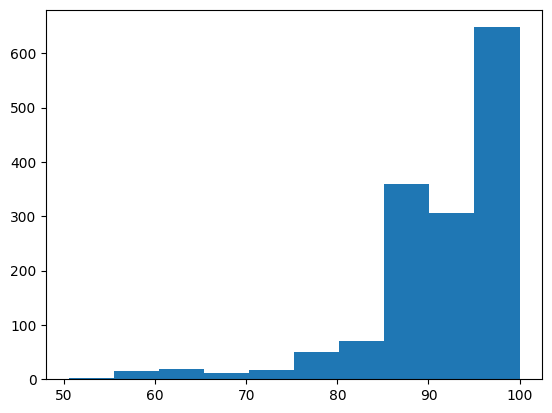

In [23]:
plt.hist(prob_pred)
plt.show() 

Text(46.722222222222214, 0.5, 'True Class')

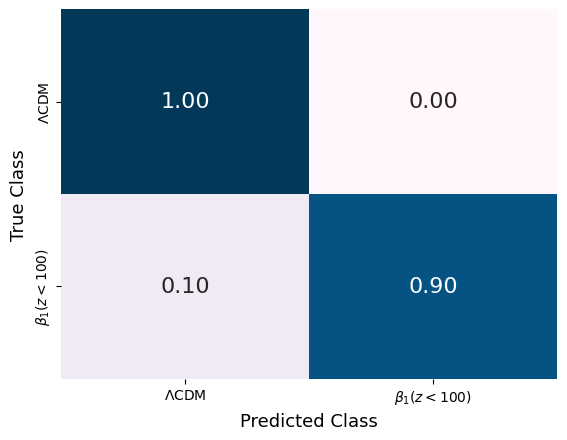

In [24]:
#Confusion matrix
from sklearn import metrics
import seaborn as sns

cm = metrics.confusion_matrix(true_model, pred_model)

#Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cm_normalized, cmap='PuBu',annot=True, annot_kws={"size": 16},cbar=False, fmt=".2f",
            xticklabels=[r'$\Lambda$CDM', r'$\beta_1(z<100)$'],
            yticklabels=[r'$\Lambda$CDM', r'$\beta_1(z<100)$'])

plt.yticks(rotation=90)

plt.xlabel('Predicted Class',fontsize=13)
plt.ylabel('True Class',fontsize=13)